# Определение возраста покупателей

### Описание пректа

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов.

Исходные данные:

Датасет: ~7.6 тыс. фотографий людей с указанием возраста (от 1 до 100 лет).

Формат данных:
* Изображения в формате .jpg
- CSV файл с соответствиями: file_name - real_age

Особенности:
* Разрешение фото варьируется.
- Есть небольшой дисбаланс по возрастным группам (меньше пожилых людей).

### Цель работы

Разработать модель компьютерного зрения для определения возраста покупателей по фотографиям в реальном времени.

Решение будет использоваться в сетевом супермаркете «Хлеб-Соль» для:
* Персонализации маркетинга — предложения товаров, соответствующих возрастной группе покупателя.
- Контроля продаж алкоголя — автоматической проверки возраста при покупке возрастных товаров.

Главный критерий качества модели: МАЕ < 8

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# Загрузка меток
labels = pd.read_csv('/datasets/faces/labels.csv')

# Размер выборки
print(f"Общее количество изображений: {labels.shape[0]}")
labels.info()

Общее количество изображений: 7591
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


## Исследовательский анализ данных

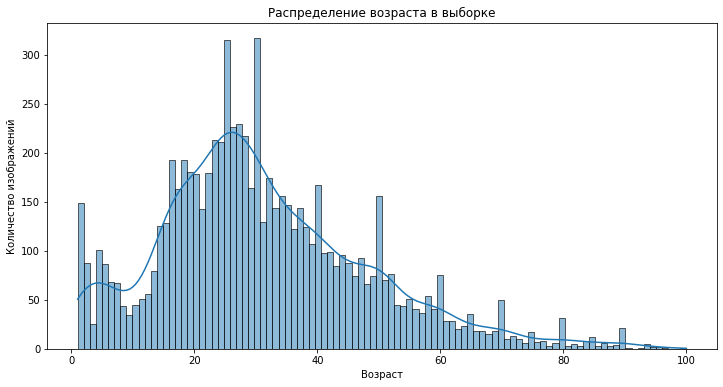

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [7]:
#построим график распределения возраста в выборке
plt.figure(figsize=(12, 6))
sns.histplot(labels['real_age'], bins=100, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

print(labels['real_age'].describe())

Found 15 validated image filenames.


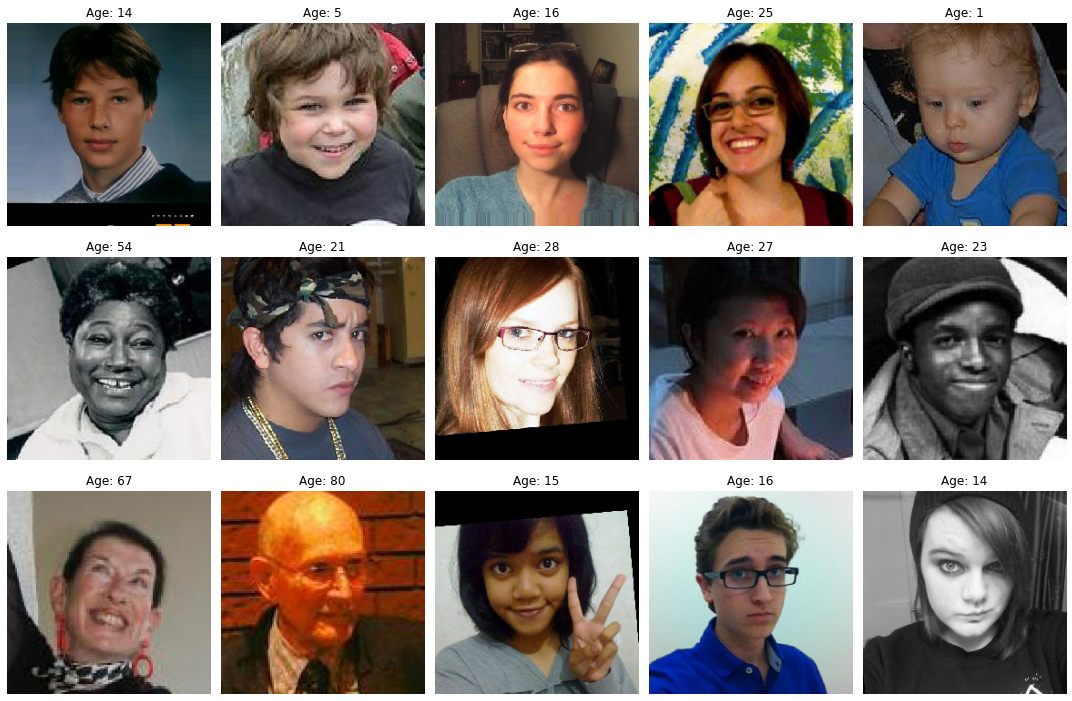

In [4]:
#напечатаем фотографии и посмотрим как устроен датасет
# Создаем генератор для просмотра изображений
datagen = ImageDataGenerator(rescale=1./255)
sample_generator = datagen.flow_from_dataframe(
    dataframe=labels.sample(15),
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=15
)

# Получаем пакет изображений
sample_images, sample_labels = next(sample_generator)

# Отображаем изображения
plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Age: {int(sample_labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Вывод по исследовательскому анализу данных.

#### Размер выборки:
    Датасет содержит 8 тысяч изображений, что, вероятно, является достаточным для обучения модели определения возраста
#### Распределение возраста:
    Возрастной диапазон от 1 до 100 лет.
    Средний возраст составляет 31 год.
    Распределение скошенное влево с пиком в районе 25-30 лет.
    
Это может привести к тому, что модель будет лучше определять возраст в диапазонах с большим количеством примеров.

#### Характеристики изображений:
Изображения содержат лица крупным планом в разных ракурсах.

Имеются различия в освещении, фоне, цветах изображения.

Некоторые изображения могут содержать очки/повязки на глаз.

Это потребует использования аугментации данных для улучшения обобщающей способности модели.

## Обучение модели

```python

import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def load_train(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1]
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )
    
    return train_generator

def load_test(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    
    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        seed=42
    )
    
    return test_generator

def create_model(input_shape):
    base_model = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(1, activation='relu')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_model(model, train_data, test_data, batch_size=32, epochs=35, steps_per_epoch=50, validation_steps=10):
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    
    return model

```

### Результаты работы модели

```

Epoch 1/35
50/50 - 36s - loss: 936.0877 - mae: 25.7382 - val_loss: 744.2339 - val_mae: 22.7649
Epoch 2/35
50/50 - 31s - loss: 242.3014 - mae: 11.8781 - val_loss: 487.2986 - val_mae: 17.5666
Epoch 3/35
50/50 - 32s - loss: 167.8534 - mae: 9.8295 - val_loss: 355.4482 - val_mae: 14.6069
Epoch 4/35
50/50 - 30s - loss: 139.5345 - mae: 9.0001 - val_loss: 318.4398 - val_mae: 13.5138
Epoch 5/35
50/50 - 32s - loss: 142.6708 - mae: 9.0108 - val_loss: 238.9099 - val_mae: 11.4159
Epoch 6/35
50/50 - 31s - loss: 126.8604 - mae: 8.4512 - val_loss: 223.1994 - val_mae: 11.2582
Epoch 7/35
50/50 - 31s - loss: 109.4034 - mae: 8.0857 - val_loss: 207.5572 - val_mae: 10.4032
Epoch 8/35
50/50 - 31s - loss: 115.4201 - mae: 8.1102 - val_loss: 206.4676 - val_mae: 10.4631
Epoch 9/35
50/50 - 30s - loss: 98.9213 - mae: 7.5101 - val_loss: 203.2969 - val_mae: 10.4400
Epoch 10/35
50/50 - 31s - loss: 92.0819 - mae: 7.2176 - val_loss: 170.8839 - val_mae: 9.5077
Epoch 11/35
50/50 - 31s - loss: 96.5862 - mae: 7.3685 - val_loss: 183.3448 - val_mae: 9.8657
Epoch 12/35
50/50 - 31s - loss: 84.8698 - mae: 7.0059 - val_loss: 160.1777 - val_mae: 9.3703
Epoch 13/35
50/50 - 31s - loss: 80.6670 - mae: 6.7897 - val_loss: 120.5162 - val_mae: 8.3497
Epoch 14/35
50/50 - 32s - loss: 75.1448 - mae: 6.5602 - val_loss: 148.7693 - val_mae: 9.3074
Epoch 15/35
50/50 - 31s - loss: 72.5278 - mae: 6.4323 - val_loss: 130.7764 - val_mae: 8.7055
Epoch 16/35
50/50 - 30s - loss: 65.2598 - mae: 6.2340 - val_loss: 169.0392 - val_mae: 9.4899
Epoch 17/35
50/50 - 32s - loss: 64.2616 - mae: 6.1011 - val_loss: 162.4337 - val_mae: 9.7421
Epoch 18/35
50/50 - 31s - loss: 62.7712 - mae: 6.0629 - val_loss: 137.4106 - val_mae: 9.3399
Epoch 19/35
50/50 - 30s - loss: 58.3182 - mae: 5.7726 - val_loss: 130.0466 - val_mae: 8.6795
Epoch 20/35
50/50 - 31s - loss: 56.7418 - mae: 5.8058 - val_loss: 138.0712 - val_mae: 8.8648
Epoch 21/35
50/50 - 31s - loss: 58.0502 - mae: 5.8273 - val_loss: 128.1394 - val_mae: 8.6959
Epoch 22/35
50/50 - 30s - loss: 52.2639 - mae: 5.4900 - val_loss: 137.6519 - val_mae: 8.7894
Epoch 23/35
50/50 - 31s - loss: 49.3045 - mae: 5.3821 - val_loss: 143.2556 - val_mae: 9.1056
Epoch 24/35
50/50 - 31s - loss: 45.4499 - mae: 5.1113 - val_loss: 146.0543 - val_mae: 9.2639
Epoch 25/35
50/50 - 31s - loss: 47.3649 - mae: 5.2448 - val_loss: 153.1086 - val_mae: 9.4033
Epoch 26/35
50/50 - 31s - loss: 49.9232 - mae: 5.3966 - val_loss: 144.3264 - val_mae: 9.1589
Epoch 27/35
50/50 - 31s - loss: 42.7321 - mae: 5.0286 - val_loss: 139.8416 - val_mae: 9.5897
Epoch 28/35
50/50 - 31s - loss: 40.4862 - mae: 4.7973 - val_loss: 129.5172 - val_mae: 8.6591
Epoch 29/35
50/50 - 32s - loss: 46.8743 - mae: 5.1597 - val_loss: 126.0080 - val_mae: 8.9202
Epoch 30/35
50/50 - 30s - loss: 41.1048 - mae: 4.8570 - val_loss: 125.0275 - val_mae: 8.5660
Epoch 31/35
50/50 - 31s - loss: 37.8300 - mae: 4.6219 - val_loss: 130.9733 - val_mae: 8.5315
Epoch 32/35
50/50 - 31s - loss: 37.5634 - mae: 4.6392 - val_loss: 139.6953 - val_mae: 8.9925
Epoch 33/35
50/50 - 31s - loss: 37.7082 - mae: 4.7208 - val_loss: 148.5357 - val_mae: 9.4262
Epoch 34/35
50/50 - 30s - loss: 39.8785 - mae: 4.8637 - val_loss: 130.3440 - val_mae: 8.6943
Epoch 35/35
50/50 - 31s - loss: 37.1169 - mae: 4.6155 - val_loss: 118.3466 - val_mae: 8.2789

238/238 - 44s - loss: 101.4908 - mae: 7.5225
```

## Анализ обученной модели

### Цель проекта

Мы разработали модель компьютерного зрения для определения возраста покупателей по фотографиям. Это поможет:

- Анализировать покупки и предлагать персонализированные рекомендации.
- Контролировать продажу алкоголя, предотвращая нарушения.

### Используемая модель

* Архитектура: Transfer Learning на основе ResNet50 с дообучением.

Дополнительные слои:
- GlobalAveragePooling2D()
- BatchNormalization()
- Полносвязные слои (Dense) с регуляризацией (L2) и Dropout для борьбы с переобучением.
- Функция активации на выходе: ReLU.

### Предобработка данных

* Аугментация: повороты, сдвиги, отражения, изменение яркости.
- Нормализация: стандартная предобработка для ResNet50 (preprocess_input).
- Разделение данных: 80% — тренировочные, 20% — валидационные.

#### Результаты:

MAE: ≈7.52 лет

В среднем модель ошибается на 7.5 лет.
Для задачи анализа покупок и контроля продаж алкоголя такая точность достаточна, так как:
* Погрешность не критична для маркетинговых рекомендаций. Почти всегда будет понятно, в какую возрастную категорию входит покупатель.
- Для проверки возраста при продаже алкоголя модель может использоваться как дополнительный фильтр (например, если предсказанный возраст <25 лет, то кассир проверяет документы).

### Возможные улучшения:

1. Увеличение датасета и улучшение баланса по возрастным группам поможет легче/точнее обучить модель. Один из вариантов - добавить аугментацию именно для пожилых людей, добавить какие-либо возрастные артефакты(морщины, седина, очки)
2. Упрощение модели. В настоящем виде модель все еще склонна к переобучению, возможно стоит попробовать более легкие модели, или заняться fine-tuning существующей(убрать некоторые слои, например)
3. Для улучшения маркетинговых рекомендаций, стоит добавить пост-обработку предсказаний(дробные значения возраста нерелевантны.
4. Добавить мультимодальность. Например, какие позиции выбирают покупатели в каждом возрасте или добавить анализ времени покупки(пенсионеры могут посещать магазин чаще с утра, а взрослые работающие люди - после работы)
